<div style="color:red;font-size:40px;">
<center>
<font size="6" >
به نام خدا 
<br><br>
<font size="5" color="grey" >
<b>
README
خوشه بندی بر روی کدهای 


</b>
<br>
<font size="4" color="black">
دانشجویان:
<br>
 (98101339) سایه جارالهی 
<br>
 (98171104) بردیا محمدی 
<br>
امیررضا سلیمان‌بیگی (98109837)
<br>
استاد: دکتر احسان‌الدین عسگری
</center>
<br>
</div>

In [ ]:
import numpy  as np
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot  as plt


## Crawling

In [ ]:
from pathlib import Path
import json
import re
import requests
import base64
import codecs
import time
import config


def check_rate_limit(headers):

    url = 'https://api.github.com/rate_limit'
    response = requests.get(url, headers=headers)
    result = response.json()
    # print(result)
    for key, value_out in result.items():
        if key == 'rate' and value_out['remaining'] == 0:
            return False
        elif key == 'resources':
            for _, value_in in value_out.items():
                if value_in['remaining'] == 0:
                    return False
    return True


def get_repos_dict(headers, language: str, min_size: str = '500', max_size: str = '5000', stars: str = '1000'):
    url = 'https://api.github.com/search/repositories'
    params = {
        # in KB
        'q': f'size:{min_size}..{max_size} stars:>={stars} is:public language:{language}',
        'sort': 'stars',
        'order': 'desc',
        'per_page': 30,
        'page': 1
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != requests.codes.ok:
        handle_error('Error in get_repos_dict', headers)
        response = requests.get(url, headers=headers, params=params)
    result = response.json()
    # print(response.url)
    # print('count: {}, language: {}'.format(result["total_count"], language))
    repos_dict = []
    for repo in result['items']:
        repos_dict.append({
            "url": repo["html_url"],
            "content_url": repo["contents_url"][:-7],
            "dir_name": re.sub('/', '_', repo["full_name"]),
            "language": repo["language"]
        })
    return repos_dict


def save_repos_files(token: str):

    headers = {
        'Accept': 'application/vnd.github.v3+json',
        'Authorization': f'token {token}'
    }

    programming_languages = json.loads(
        Path('programming_languages.json').read_text()
    )

    programming_languages_dict = {
        language["format"]: language["name"] for language in programming_languages
    }

    repos_dict = []
    for language in programming_languages:
        if language["crawl"]:
            print(language)
            repos_dict += get_repos_dict(
                headers=headers,
                language=language['name']
            )
        # break

    save_repos_content(headers, programming_languages_dict, repos_dict)
    Path('repos_dict.json').write_text(json.dumps(repos_dict))


def save_repos_content(headers, programming_languages_dict, repos_dict):
    data_path = Path('data')
    if data_path.exists():
        data_path.rmdir()
    data_path.mkdir()

    for repo in repos_dict:
        print(repo["content_url"], repo["dir_name"])
        repo_path = Path(data_path.name) / repo["dir_name"]
        repo_path.mkdir()

        response = requests.get(repo["content_url"], headers=headers)
        if response.status_code != requests.codes.ok:
            handle_error('Error in save_repos_content', headers)
            response = requests.get(repo["content_url"], headers=headers)
        content = response.json()

        start_time = time.time()
        files_url = get_repo_files_url(
            headers,
            content,
            programming_languages_dict,
            start_time
        )
        repo["files_url"] = files_url

        # print(files_url)

        # for file in files_url:
        #     save_file(headers, file, repo_path)
        # break


def get_repo_files_url(headers, content, programming_languages_dict, start_time, root_name=''):

    if time.time() - start_time > 120:
        return []

    files_url = []
    # print(root_name)
    for item in content:
        name = item["name"]
        # print(name)
        if item["type"] == "file" and re.match('^.*\..+$', name):
            format = re.search('^.*\.(.+?)$', name).group(1)
            if format in programming_languages_dict:
                files_url.append({
                    "url": item["url"],
                    "name": f'{root_name}.{name}' if root_name != '' else name,
                    "language": programming_languages_dict[format]
                })

        elif item["type"] == "dir":
            response = requests.get(item["url"], headers=headers)
            if response.status_code != requests.codes.ok:
                handle_error('Error in get_repo_files_url', headers)
                response = requests.get(item["url"], headers=headers)
            files_url += get_repo_files_url(
                headers,
                response.json(),
                programming_languages_dict,
                start_time,
                root_name=f'{root_name}.{name}' if root_name != '' else name
            )

    return files_url


def save_file(headers, file, repo_path):

    response = requests.get(file["url"], headers=headers)
    if response.status_code != requests.codes.ok:
        handle_error('Error in save_file', headers)
        response = requests.get(file["url"], headers=headers)
    result = response.json()

    if result["encoding"] != "base64":
        print("Error, encoding is not base64, url: {url}".format(
            url=file["url"]))
        decoded_content = result["content"]
    else:
        content = base64.b64decode(result["content"])
        decoded_content = codecs.decode(content)

    language_path = Path(str(repo_path)) / file["language"]
    if not language_path.exists():
        language_path.mkdir()

    file_path = Path(str(language_path)) / f'{file["name"]}.txt'
    file_path.write_text(decoded_content)


def handle_error(error_message: str, headers):
    print(error_message)
    while True:
        time.sleep(60)
        if check_rate_limit(headers):
            break

In [ ]:
save_repos_files(token=config.token)

## Convert data to CSV 

In [ ]:
import os 
import pandas as pd

REPO_NAME = 'repo_name'
FILE_NAME = 'file_name'
LANG = 'lang'
CODE = 'code'
valid_languages = ['Java', 'Python', 'Shell', 'C++', 'Go']
def get_code_df(dirr):
    code_df = pd.DataFrame(columns=[REPO_NAME, FILE_NAME, LANG, CODE])
    for addr, folders, files in os.walk(dirr):
        if not folders:
            temp = get_files(addr, files)
            if type(temp) != bool:
                code_df = code_df.append(temp, ignore_index=True)
            else:
                pass
    return code_df
            

def get_files(folder_addr, file_names:list):
    result = []
    repo_name = folder_addr.split('/')[-2]
    lang = folder_addr.split('/')[-1]
    if lang not in valid_languages:
        return False
    for file in file_names:
        splitted_name = file.split('.')
        name = '.'.join(splitted_name[0:-2])
        code = ''
        with open(folder_addr+'/'+file, 'r') as ff:
            code = ff.readlines()
            code = ''.join(code)
        result.append((repo_name, name, lang, code))
    return pd.DataFrame(result ,columns=[REPO_NAME, FILE_NAME, LANG, CODE])
    
data = get_code_df('preprocessed_data')
data.to_csv('code_v1.csv')

In [ ]:
def get_part_of_data(count):
    data1 =  pd.DataFrame(columns=[REPO_NAME, FILE_NAME, LANG, CODE])
    for langg in valid_languages:
        data1 = data1.append(data.loc[data[LANG] == langg][0:count], ignore_index = True)
    return data1

data1 = get_part_of_data(200)
true_labels = [0]*200 + [1] *200 + [2]*200 + [3]*200 + [4]*200


## Preprocess

In [ ]:
import json
import re
from pathlib import Path


def remove_multi_line_comments(string: str) -> str:

    # ruby comments
    multi_line_ruby_regex = re.compile(
        r'''(
        (?<=\n=begin).*?(?=\n=end\s*\n) |
        (?<=^=begin).*?(?=\n=end\s*\n) |
        (?<=\n=begin).*?(?=\n=end$) |
        (?<=^=begin).*?(?=\n=end$)
        )''',
        flags=re.DOTALL | re.VERBOSE | re.MULTILINE
    )
    string = multi_line_ruby_regex.sub('\n', string)

    # Python comments
    multi_line_python_regex = re.compile(
        r'''(
            (?<=\n)\'{3}.*?\'{3}(?=\s*\n) |
            (?<=^)\'{3}.*?\'{3}(?=\s*\n) |
            (?<=\n)\'{3}.*?\'{3}(?=$) |
            (?<=^)\'{3}.*?\'{3}(?=$) |
            (?<=\n)\"{3}.*?\"{3}(?=\s*\n) |
            (?<=^)\"{3}.*?\"{3}(?=\s*\n) |
            (?<=\n)\"{3}.*?\"{3}(?=$) |
            (?<=^)\"{3}.*?\"{3}(?=$)
        )''',
        flags=re.DOTALL | re.VERBOSE | re.MULTILINE
    )
    string = multi_line_python_regex.sub('\''*6, string)

    multi_line_comment_regex = re.compile(
        r'''(
        (?<=\n/\*).*?(?=\*/\s*\n) |
        (?<=^/\*).*?(?=\*/\s*\n) |
        (?<=\n/\*).*?(?=\*/$) |
        (?<=^/\*).*?(?=\*/$)
        )''',
        flags=re.DOTALL | re.VERBOSE | re.MULTILINE
    )
    string = multi_line_comment_regex.sub('', string)

    return string


def remove_inline_comments(string: str) -> str:
    inline_regex = re.compile(
        r'''(
            (?<=//).+ | # comments like: // This is a comment
            (?<=\#).+ # comments like: # This is a comment
        )''',
        flags=re.VERBOSE
    )
    return inline_regex.sub('', string)


def replace_numbers(string: str) -> str:
    num_regex = re.compile(
        r'''(
            (?<!\w)\d+
        )''',
        flags=re.VERBOSE
    )
    # return num_regex.findall(string)
    return num_regex.sub('NUM', string)


def remove_indents(string: str) -> str:
    regex = re.compile(
        r'''(
            (?<=\n)\s+ |
            (?<=^)\s+
        )''',
        flags=re.VERBOSE
    )
    return regex.sub('', string)


def remove_strings(string: str) -> str:

    str_qoute_text_regex = re.compile(
        r'''(
            \".*?\" |
            \'.*?\'
        )''',
        flags=re.VERBOSE | re.DOTALL
    )
    string = str_qoute_text_regex.sub('\"\"', string)

    str_multi_qoute_text_regex = re.compile(
        r'''(
            \"{3}.*?\"{3} |
            \'{3}.*?\'{3}
        )''',
        flags=re.VERBOSE | re.DOTALL
    )
    string = str_multi_qoute_text_regex.sub('\"\"\"\"\"\"', string)

    return string


def extract_tokens(string: str) -> str:
    num_id_regex = re.compile(
        r'''(
            (?<=\W) |
            (?=\W)
        )''',
        flags=re.VERBOSE
    )
    return num_id_regex.sub(' ', string)


def preprocess(string: str):
    string = remove_indents(string)
    string = replace_numbers(string)
    string = remove_inline_comments(string)
    string = remove_multi_line_comments(string)
    string = remove_strings(string)
    string = extract_tokens(string)
    string = re.sub('\s+', ' ', string)
    return string


def preprocess_repos():
    repos_dict = json.loads(Path('repos_dict.json').read_text())

    preprocessed_data_path = Path('preprocessed_data')
    preprocessed_data_path.mkdir()

    for repo in repos_dict:

        last_repo_path = Path('data') / repo["dir_name"]
        repo_path = Path(str(preprocessed_data_path)) / repo["dir_name"]
        print(repo_path)
        repo_path.mkdir()

        for file in repo["files_url"]:
            # print(file)
            preprocess_file(last_repo_path, repo_path, file)
            # break
        # break


def preprocess_file(last_repo_path, repo_path, file):

    language_path = Path(str(repo_path)) / file["language"]
    if not language_path.exists():
        language_path.mkdir()

    code_path = Path(
        str(language_path)) / f'{file["name"]}.txt'
    # print(code_path)
    last_code_path = Path(str(last_repo_path)) / \
        file["language"] / f'{file["name"]}.txt'
    if not last_code_path.exists():
        return
    # print(last_code_path)
    code = last_code_path.read_text()
    preprocessed_code = preprocess(code)
    code_path.write_text(preprocessed_code)


string = '''/* first
second
third */
ali ajsjnajsn
/* first C comment
second C comment
third C comment */
\'\'\'first quote comment
second quote comment
third quote comment
\'\'\'
a = ali
\'\'\'first quote comment
second quote comment
third quote comment
\'\'\'

\"\"\"
first double quote line of the comment
second double quote line of the commet
\"\"\"
/* first C comment
second C comment
third C comment */
=begin
jsjdisjdij =begin
skndksdknsd =end
skndksndk
=end

'''


inline_str = '''
jsjansj = ajnsjan #habsajsasa
# hbshabshb aknsjnas
//ksjnjasjna
nkans = asajsn
'''


path = Path('preprocessed_data')
preprocess_repos()


## Clustring 

In [ ]:
def get_vectorized_data(data):
    '''

    :param data: a list of strings, each string is a code that tokens are concatenated with one space
    :return:
    '''
    vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=None, norm='l2')
    X = vectorizer.fit_transform(data)
    return X



In [ ]:
vectorized_data = get_vectorized_data(data1[CODE])


In [ ]:
vectorized_data.shape

(1000, 160960)

In [ ]:
def get_kmeans(vec_data):
    kmeans = KMeans(n_clusters=5, random_state=0).fit(vec_data)
    return kmeans

def predict_kmeans(kmeans, data):
    return kmeans.predict(data)



In [ ]:
kmeans = get_kmeans(vectorized_data)


In [ ]:
prediction = predict_kmeans(kmeans, vectorized_data)

## Calculate purity score
The purity score is acceptable. 

In [ ]:
def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    return accuracy_score(y_true, y_voted_labels)



In [ ]:
true_labels = [1] * 200 + [3] * 200 +[2] * 200 +[4] * 200 +[0] * 200
purity_score(np.array(true_labels), kmeans.labels_)

0.588

## Visualizer

In [ ]:
from yellowbrick.text import TSNEVisualizer

def plotted_scatter(vectorized_data, label):
    tsne = TSNEVisualizer()
    tsne.fit(vectorized_data, label)
    tsne.show()



<div dir= "rtl">
در دو تصویر زیر، نمودار گرافی مربوط به لیبل های اصلی و حدس زده شده بررسی میشود. همانطور که دیده میشود، به طور نسبی میتوان گفت که کلاسترینگ انحام شده مطابق با دسته های اصلی است. 
</div>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

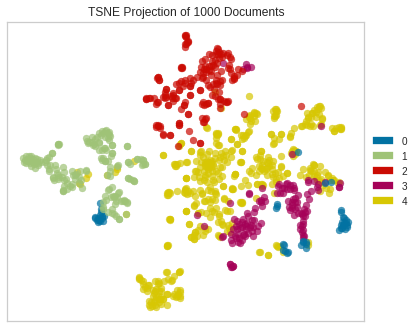

In [ ]:
plotted_scatter(vectorized_data, prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* a

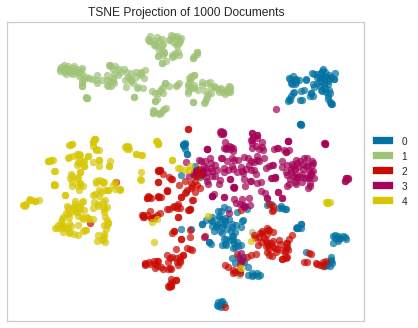

In [ ]:
plotted_scatter(vectorized_data, true_labels)

## Calculating RSS

In [ ]:
kmeans.inertia_

926.0892674780534

## Test concatanated repo codes 

In [ ]:
repos_dict = json.loads(Path('repos_dict.json').read_text())

In [ ]:
def get_concatanated(d):
    text = ''
    for addr, folders, files in os.walk(f'preprocessed_data/{d}'):
        print('hi')
        for file in files:
            with open(f'preprocessed_data/{d}/{file}', 'r') as ff:
                code = ff.readlines()
                code = ''.join(code)
                text += code
                text += ' '
    return text

def get_valid_test():
    for d in repos_dict:
        if d['language'] not in valid_languages:
            print('hi', d['dir_name'])
            continue
        for ff in d['files_url']:
            if ff['language'] not in valid_languages:
                print('hiss', d['dir_name'])
                continue
        if d['dir_name'] in data[REPO_NAME]:
            return get_concatanated(data.loc[data['repo_name'] == d['dir_name']]), d['language']
    return False
        

## Technical Report 

<div dir = "rtl">

در این تمرین از الگوریتم k-means که یک الگوریتم خوشه‌بندی unsupervised است، برای خوشه‌بندی کدهای سایت Github در گروه‌های مختلف استفاده خواهیم کرد.

هدف K-means به این صورت است که نقاط داده مشابه را با هم گروه بندی کنید و الگوها را کشف کنید. برای دستیابی به این هدف، K-means به دنبال تعداد مشخصی (k) از centroid در یک مجموعه داده می‌گردد. Centroid  به خوشه ای اشاره دارد که مجموعه ای از نقاط داده است که به دلیل شباهت های خاصی با یکدیگر جمع شده اند. "means" در K-means به میانگین گیری داده ها و به عبارت دیگر یعنی یافتن centroid اشاره دارد. و این الگوریتم بدون نظارت یا unsupervised است، زیرا ما هیچ دانش قبلی در مورد خوشه ها یا کلاس های مجموعه داده خود نداریم و به عبارتی گروه های پنهان را در مجموعه داده خود خواهیم یافت. 

</div>


<div dir = "rtl">
<b>
مراحل
</b>

1. مجموعه کد های Github را اکسپلور کنیم 
2. داده ها مجموعه داده را مهندسی کنیم تا بهترین عملکرد را از الگوریتم K-means بدست آوریم
3. الگوریتم را چندین بار اجرا کنید، هر بار با تعداد متفاوتی از خوشه ها آزمایش کنید
4. از معیارهای مختلف برای تجسم نتایج و یافتن بهترین تعداد خوشه ها استفاده کنید 
5. تجزیه و تحلیل خوشه ها

</div>
<div dir= "rtl">
<br>
    در این تمرین repository های گیتهاب را کرال کرده‌ایم. 
<br>
<b>Crawling:</b><br>
     برای کرال کردن از api گیتهاب استفاده کردیم که داکیومنتیشن آن در https://docs.github.com/en/rest/guides/getting-started-with-the-rest-api موجود است. سپس ابتدا repoهای موجود در گیتهاب را بر اساس زبانی غالب در آن crawl کردیم. سپس در هر repo به اینصورت عمل کردیم که فایل‌های مرتبط به زبان‌های برنامه نویسی مورد نظر را گرفتیم. این زبان‌ها شامل Python، JavaScript، Java، TypeScript، Go، C، Ruby، PHP، C#، C++، Shell و Kotlin است.این زبان‌ها بر اساس سایت https://madnight.github.io/githut/#/pull_requests/2021/4 شامل بیش از 1 درصد از گیتهاب می‌شوند. مراحل crawl کردن به اینصورت بود که ابتدا لیست repositoryها را بر اساس زبان غالب آنها جستوجو می‌کردیم. فیلتری که داشتم در این بخش این بود که repoهایی که stars آنها بیشتر از 1000 بودند و حجم آنها بین 1MB تا 5MB بود را crawl می‌کردیم. این repo ها از stars بیشتر به کمتر سورت شده بودند. سپس در هر repo تمامی فایل‌ها را بررسی می‌کردیم و اگر به فایلی خوردیم که زبان مورد نظر ما را دارا بود، آن را crawl می‌کردیم. از چالش‌هایی که در crawl کردن به آن برخوردیم این بود که بعضی از repoها فایل‌های زیادی داشتند. در نتیجه مجبور شدیم که اگر در crawl کردن repoای بیشتر از 2 دقیقه منتظر ماندیم آن را prune کنیم. بعد از اینکه urlهای مربوط به تمام فایل‌های یک repo را جمع آوری کردیم، آنها را به اینصورت در فایل‌ها ذخیره می‌کنیم که folder اصلی داده‌ها data نام دارد. سپس در آن folderهایی با نام repository مربوطه و user ایجاد کننده آن repository وجود دارد. که با "_" از هم جدا شده‌اند. سپس درون هر repo ابتدا folderهایی با نام زبان‌های برنامه نویسی‌ای که در آن repo موجود بوده می‌سازیم. سپس فایل‌های مربوط به هر زبان را در آنجا به فرمت txt ذخیره می‌کنیم. برای اینکه ممکن است چند فایل کد با اسم یکسان در repositoryها وجود داشته باشد، نام آنها را بر اساس folderهایی که آمدیم تا به آن برسیم می‌گذاریم و آن نام ها را با نقطه از یکدیگر جدا می‌کنیم. همچنین چالش‌هایی هم مربوط به limitهای requestها داشتیم که به اینصورت عمل می‌کردیم که اگر limit مربوطه به پایان رسید، یک دقیقه برنامه را به sleep می‌بردیم و limit را دوباره چک می‌کردیم، در صورتی که امکان request داشتیم به برنامه ادامه می‌دادیم و در غیراینصورت دوباره برنامه را به یک دقیقه sleep می‌بردیم.
<br>
<b>PreProcessing:</b>
<br>
اولین قدمی که در زمینه preprocessing برداشتیم این بود که فاصله‌های مربوط به اول هر خط را برداشتیم. سپس عددهای داخل هر برنامه را با توکن NUM جایگزین کردیم. سپس متن تمامی کامنت‌های یک خطی را برداشتیم. می‌دانستیم که در تمامی برنامه‌ها کامنت‌های یک خطی با "#" یا "//" شروع می‌شوند. سپس متن تمامی کامنت‌های چند خطی را برداشتیم. کامنت‌های چند خطی یا شامل /*comment*/، """comment"""، '''comment''' و یا =begin comment =end است. سپس متن داخل تمامی stringها را حذف می‌کنیم. tokenهای مربوطه را با اسپیس از هم جدا می‌کنیم. و در نهایت تمامی فاصله‌ها را با اسپیس جایگزین می‌کنیم.
<br>

</div>


<div dir = "rtl">
<b>
 تبدیل به بردار با استفاده از tf-idf
</b>

اکنون ما تابع TF-IDF را اعمال خواهیم کرد، که یک آمار عددی است که با دادن امتیازی از 0 تا 1 به هر کلمه در یک سند، نشان می دهد که چقدر یک کلمه برای یک سند در یک مجموعه مهم است.

</div>



<div dir = "rtl">
<b>
purity
</b>

برای محاسبه purity، هر خوشه به کلاسی که بیشترین فراوانی را در خوشه دارد، اختصاص داده می شود و سپس دقت این تخصیص با شمارش تعداد اسناد به درستی اختصاص داده شده و تقسیم بر تعداد اسناد اندازه گیری می شود. ما در اینجا فرض می‌کنیم که برچسب‌های حقیقت پایه اعداد صحیح هستند، مانند خوشه‌های پیش‌بینی‌شده، یعنی ایندکس خوشه‌ها.

</div>


<div dir = "rtl">
<b>
rand index
</b>

شاخص rand index با در نظر گرفتن همه جفت‌های  سمپل و شمارش جفت‌هایی که در خوشه‌های یکسان یا متفاوت در خوشه‌های پیش‌بینی‌شده و واقعی تخصیص داده شده‌اند، اندازه‌گیری شباهت بین دو خوشه‌بندی را محاسبه می‌کند.

</div>


<div dir = "rtl">
<b>
task description
</b>

در فاز خوشه بندی

در تلاش اول سعی شد تمامی دیتای جمع آوری شده از ریپو ها به صورت concat شده به ورودی بدهیم تا بیش ترین زبان مورد استفاده ی هر ریپو مشخص شود اما به دلیل شباهت زبان ها به یکدیگر به خروجی مناسبی نرسیدیم. 

در تلاش دوم تصمیم گرفتیم با زبان های مختلف کلاسترینگ را انجام دهیم و بعد از کلاسترینگ یک فایل را که ترکیبی از چندین زبان است را به مدلمان به ورودی دهیم و سپس خروجی را بر اساس بیشترین زبانی که مورد استفاده قرار گرفته شده کلاستر کند

در فاز دیتا

ابتدا ۱۲ زبان پر طرفدار در گیت هاب را در نظر گرفتیم اما به دلیل حجم بالای دیتا ماتریس و خروجی K-means بسیار بزرگ می شود و باعث می شود رم گوگل کولب پر شود. به همین دلیل ۵ زبان اصلی را در نظر گرفتیم که نفاوت هایشان مشهود باشد. 
اما همچنان اندازه ماتریس خروجی بسیار بزرگ می باشد و علارغم اینکه خوشه بندی انجام می شود اما امتیاز بالایی نمی گیرد. 

</div>

<div dir = "rtl">
<b>
data visualization
</b>
برای کاهش ابعاد داده جهت نمایش خوشه ها از تکنیک t-SNE استفاده کردیم. 
t-Distributed Stochastic Neighbor Embedding (t-SNE) تکنیکی برای کاهش ابعاد است که به ویژه برای تجسم مجموعه داده های با ابعاد بالا مناسب است. این تکنیک را می‌توان از طریق تقریب‌های Barnes-Hut پیاده‌سازی کرد و به آن اجازه می‌دهد در مجموعه داده‌های بزرگ دنیای واقعی اعمال شود.

کد این بخش ابتدا به صورت دستی پیاده سازی شد اما استفاده از visualizer کتابخانه yellowbrick سریع تر و بهتر داده ها و خوشه بندی هارا visualize کرد

</div>